<h1><center>Deep Unsupervised Learning<center></h1>
<center>By Valeria Bega, Theresa Wohlsen and Francesco Donato</center>


### Table of Contents

* [1. Input](#chapter1)
* [2. Model](#chapter2)
    * [2.1. Model: Version 1](#2.1)
    * [2.2. Model: Version 3](#2.2)
* [3. Train](#chapter3)
* [4. Semi-Supervised VAE (M1)](#chapter4)
* [5. Semi-Supervised VAE (M2)](#chapter5)


In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline

import seaborn as sns

sns.set_style("whitegrid")


# **1.Input** <a class="anchor" id="chapter1"></a>
We will first prepare the data. We will use what is known as binarized MNIST where all the pixels
take binary values, i.e. they are either 0 or 1.
1. Set up a script using the MNIST Dataset from torchvision.
2. Plot 64 randomly chosen samples on a 8 × 8 grid.
3. Using the transform argument, implement dynamic binarization, where the binarized {0, 1}
pixels are sampled using the pixel intensity as the probability.
4. (Report) Plot 64 randomly chosen binarized MNIST samples on a 8 × 8 grid.

In [2]:
from utils import get_mnist
train_loader, test_loader = get_mnist()
train_loader_base,_ = get_mnist(Binarized=False)

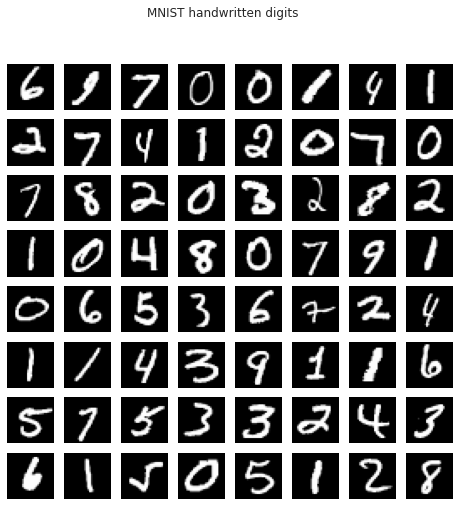

In [3]:
#plot a few MNIST examples
# Load a batch of images into memory (train_loader_base for basic MNIST)
images, labels = next(iter(train_loader_base))

fig, axs = plt.subplots(8, 8, figsize=(8, 8))

for i, ax in enumerate(axs.flat):
    ax.imshow(images[i].view(28, 28), cmap='Greys_r')
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()

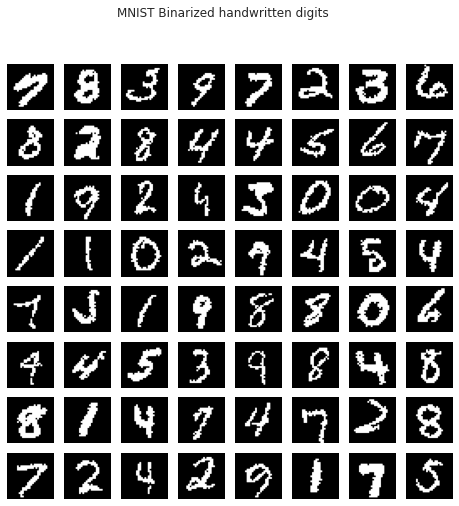

In [4]:
#plot a few Binarized MNIST examples

# Load a batch of images into memory (train_loader for Binarized MNIST)
images, labels = next(iter(train_loader))

fig, axs = plt.subplots(8, 8, figsize=(8, 8))

for i, ax in enumerate(axs.flat):
    ax.imshow(images[i].view(28, 28), cmap='Greys_r')
    ax.axis('off')

plt.suptitle('MNIST Binarized handwritten digits')
plt.show()

# **2.Model** <a class="anchor" id="chapter2"></a>

Implement a VAE as a torch.nn.Module.
1. Implement a method .encode(...) that encodes a batch of x.
2. Implement a method .decode(...) that decodes a batch of z.
3. Implement a method .sample(...) that generates samples.
4. Implement a method .elbo(...) that computes the ELBO.

VAE(
  (encoder): Encoder(
    (net): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
    )
  )
  (mu_dense): Linear(in_features=256, out_features=50, bias=True)
  (log_var_dense): Linear(in_features=256, out_features=50, bias=True)
  (decoder): Decoder(
    (net): Sequential(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=784, bias=True)
    )
  )
)


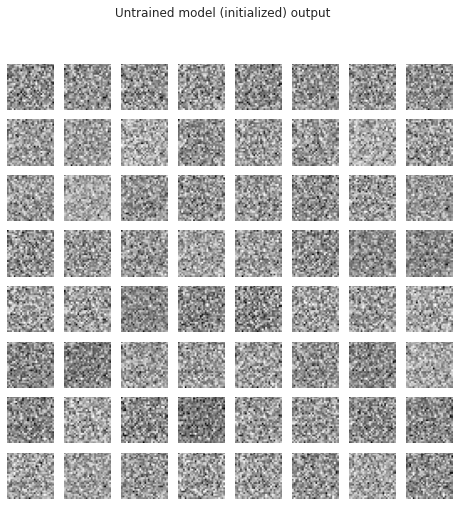

In [5]:
from models import VAE
from utils import init_weights
# test vae
num_features = 784
latent_f = 50
layers_enc = [num_features,512,256] ##Adding extra layer
layers_dec = [latent_f, 256, 512]

vae=VAE(layers_enc,layers_dec,latent_f,num_features,beta=1.0,activation="ReLU")
print(vae)
init_weights(vae)

_ , _ , _, reconstruction  = vae(images)

fig, axs = plt.subplots(8, 8, figsize=(8, 8))

for i, ax in enumerate(axs.flat):
    ax.imshow(reconstruction[i].view(28, 28).cpu().detach().numpy(), cmap='Greys_r')
    ax.axis('off')
    
plt.suptitle('Untrained model (initialized) output')
plt.show()

# **4. Semi-Supervised VAE (M1)** <a class="anchor" id="chapter4"></a>
We have now trained a VAE on the full unlabeled da
taset. We will now implement the M1 model
from Semi-Supervised Learning with Deep Generative Models. This amounts to simply training
a classifier on top of the representations learned by our VAE.
1. Extract 100 labeled datapoints from MNIST (10 from each class).

In [6]:
import torch
from collections import defaultdict
from utils import training,test
#Parameters Net
num_features = 784
latent_f = 10
layers_enc = [num_features,512,256] ##Adding extra layer
layers_dec = [latent_f, 256, 512]
BETA = 1.0

#init model + weighr
m1=VAE(layers_enc,layers_dec,latent_f,num_features, BETA, activation="ReLU")
init_weights(m1)
print(m1)

#Parameters Optimizer
LR = 3e-4
epoch = 0
EPOCH = 100 # or use 200
optimizer = torch.optim.Adam(m1.parameters(), lr=LR)
cuda = torch.cuda.is_available()
# cuda = False
print("Cuda is available :", cuda)

training_data = defaultdict(list)
validation_data = defaultdict(list)
test_data = defaultdict(list)

while epoch < EPOCH:
    epoch+= 1
    print("epoch : ", epoch)
    print(" ___________________________  TRAINING  ____________________________")
    training(m1,train_loader,optimizer,cuda,training_data)
    print(" ____________________________  TESTING  ____________________________")
    test(m1,test_loader, cuda,test_data)

.603, BCE : -89.655, KL : 17.948
 ____________________________  TESTING  ____________________________
Test loss =  -106.62 

epoch :  9
 ___________________________  TRAINING  ____________________________
elbo : -106.632, BCE : -88.569, KL : 18.062
 ____________________________  TESTING  ____________________________
Test loss =  -105.558 

epoch :  10
 ___________________________  TRAINING  ____________________________
elbo : -105.744, BCE : -87.542, KL : 18.202
 ____________________________  TESTING  ____________________________
Test loss =  -104.765 

epoch :  11
 ___________________________  TRAINING  ____________________________
elbo : -105.039, BCE : -86.728, KL : 18.311
 ____________________________  TESTING  ____________________________
Test loss =  -104.209 

epoch :  12
 ___________________________  TRAINING  ____________________________
elbo : -104.367, BCE : -85.965, KL : 18.402
 ____________________________  TESTING  ____________________________
Test loss =  -103.715 

epoc

Text(0.5, 0.98, 'Train-validation plot for VAE with beta = 1.0 and 10 latent features')

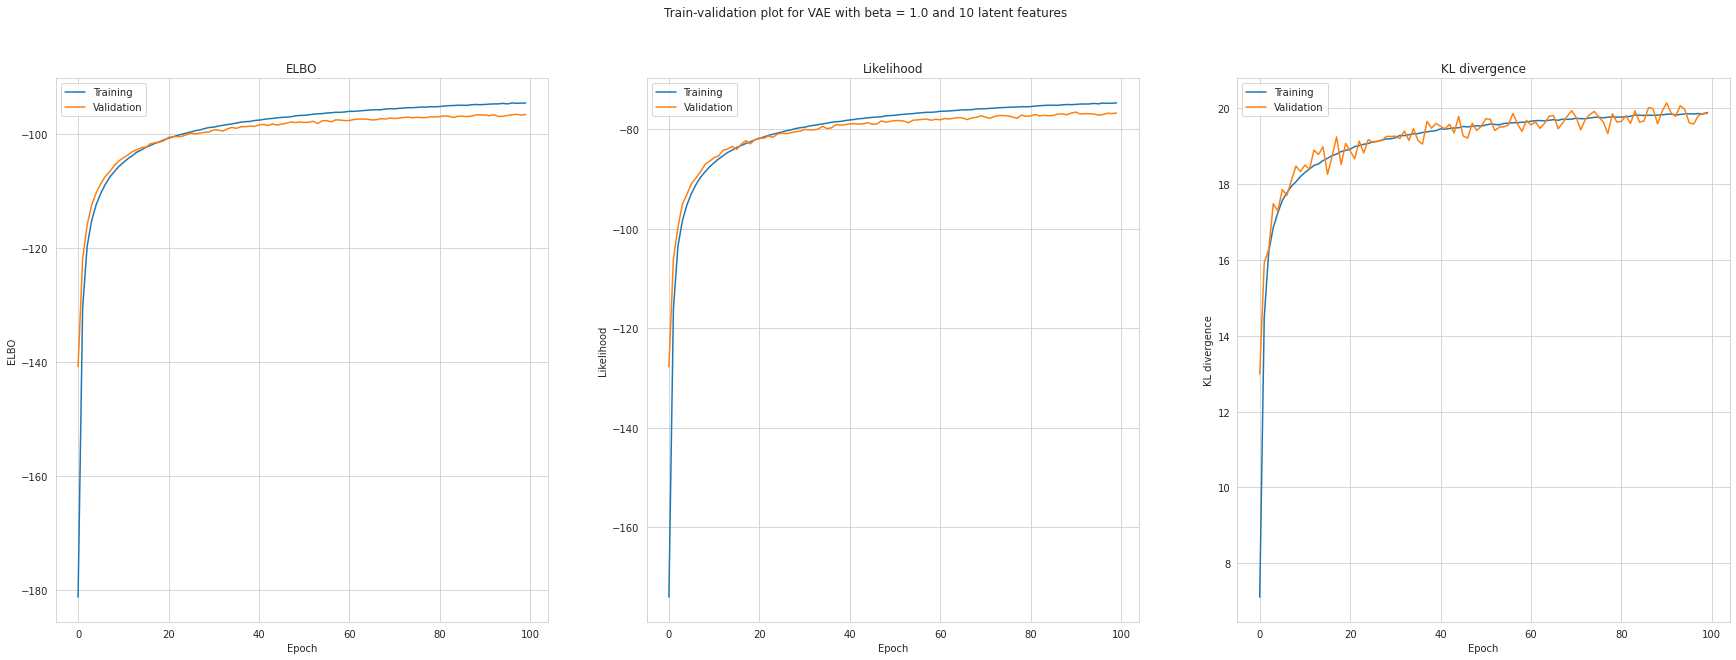

In [7]:
df_training = pd.DataFrame(training_data).rename(columns=dict(zip([name for name in training_data.keys()],["traininig_"+ name for name in training_data.keys()])))
# df_validation = pd.DataFrame(validation_data).rename(columns=dict(zip([name for name in validation_data.keys()],["validation_"+ name for name in validation_data.keys()])))
df_validation = pd.DataFrame(test_data).rename(columns=dict(zip([name for name in test_data.keys()],["validation_"+ name for name in test_data.keys()])))
df_loss =df_validation.join(df_training)

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(30,10))
sns.lineplot(x=df_loss.index, y="traininig_elbo",data=df_loss,ax=axs[0])
sns.lineplot(x=df_loss.index, y="validation_elbo",data=df_loss,ax=axs[0])
axs[0].set_title("ELBO")
axs[0].set_ylabel("ELBO")
axs[0].set_xlabel("Epoch")
axs[0].legend(["Training","Validation"])

sns.lineplot(x=df_loss.index, y="traininig_likelihood",data=df_loss,ax=axs[1])
sns.lineplot(x=df_loss.index, y="validation_likelihood",data=df_loss,ax=axs[1])
axs[1].set_title("Likelihood")
axs[1].set_ylabel("Likelihood")
axs[1].set_xlabel("Epoch")
axs[1].legend(["Training","Validation"])

sns.lineplot(x=df_loss.index, y="traininig_KL",data=df_loss,ax=axs[2])
sns.lineplot(x=df_loss.index, y="validation_KL",data=df_loss,ax=axs[2])
axs[2].set_title("KL divergence")
axs[2].set_ylabel("KL divergence")
axs[2].set_xlabel("Epoch")
axs[2].legend(["Training","Validation"])
fig.suptitle(f"Train-validation plot for VAE with beta = {BETA} and {latent_f} latent features")
# fig.savefig( "/content/drive/MyDrive/Deep Learning/Deep Learning Final Project/torch_model/loss for beta = 1.png")



### Generation of data and TSNE of Z

Text(0.5, 0.98, 'Generated samples from random noise with model trained for 100 epoch')

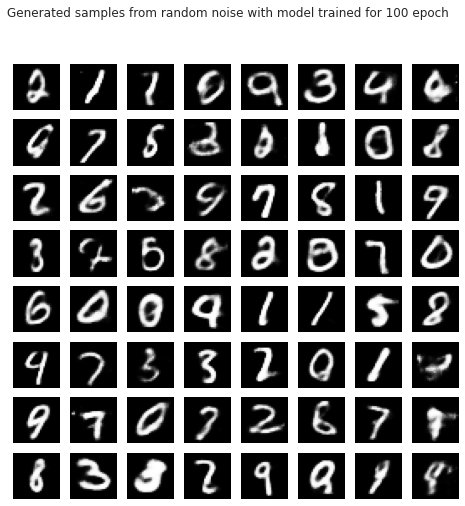

In [8]:
#Generation
m1.cpu().eval()
generated_images = m1.sample(8*8)

fig, axs = plt.subplots(8, 8, figsize=(8, 8))

for i, ax in enumerate(axs.flat):
    ax.imshow(generated_images[i].view(28, 28).detach().numpy(), cmap='Greys_r')
    ax.axis('off')
    
plt.suptitle(f'Generated samples from random noise with model trained for {epoch} epoch')

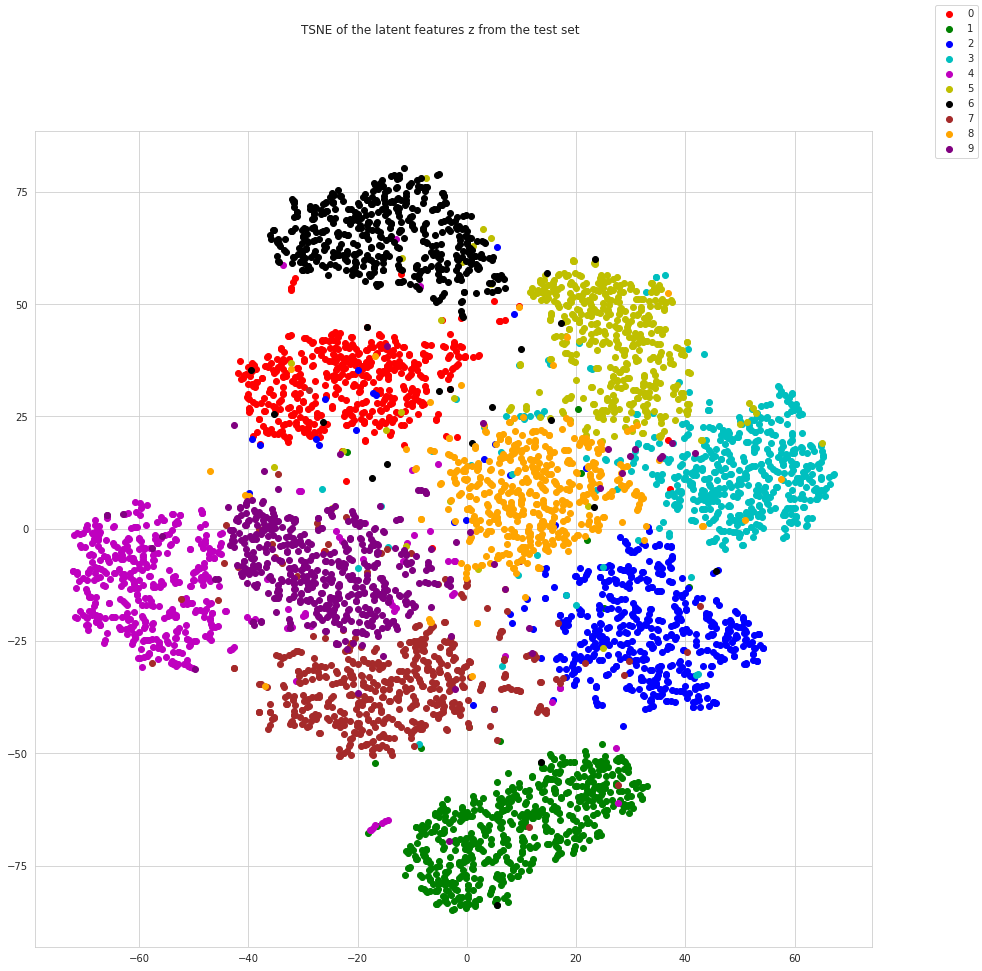

In [9]:
from sklearn.manifold import TSNE
_, test_loader_tsne = get_mnist(batch_size=5000)
images, labels = next(iter(test_loader_tsne))
images.cpu()
labels= labels.cpu().numpy()
m1.cpu().eval()

_ , _ , z , _  = m1(images)
#TSNE of Z, kinda ugly
fig3 = plt.figure(figsize=(15,15))
z = z.detach().numpy()
z = TSNE(n_components=2).fit_transform(z)
target_ids = range(len(np.unique(labels)))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'brown', 'orange', 'purple'
for i, c, label in zip(target_ids, colors, np.unique(labels)):
    plt.scatter(z[labels == i, 0], z[labels == i, 1], c=c, label=label)
fig3.legend()
fig3.suptitle("TSNE of the latent features z from the test set")

plt.show()

### Reconstruction and original binarized batch 

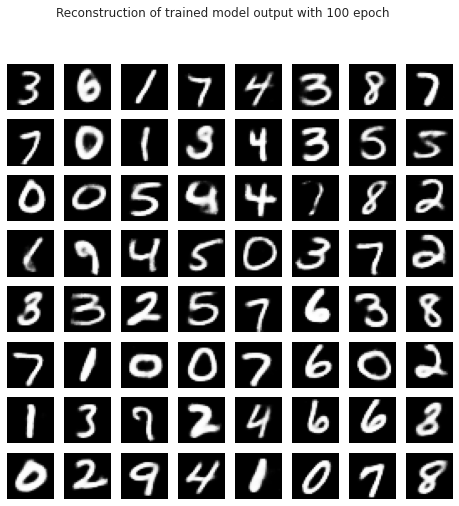

In [10]:
#reconstruction of a random batch
images, labels = next(iter(test_loader))
images.cpu()
labels= labels.cpu().numpy()
m1.cpu().eval()

_ , _ , _ , reconstruction  = m1(images)

fig1, axs = plt.subplots(8, 8, figsize=(8, 8))

for i, ax in enumerate(axs.flat):
    ax.imshow(reconstruction[i].view(28, 28).detach().numpy(), cmap='Greys_r')
    ax.axis('off')
    
plt.suptitle(f'Reconstruction of trained model output with {epoch} epoch')
plt.show()



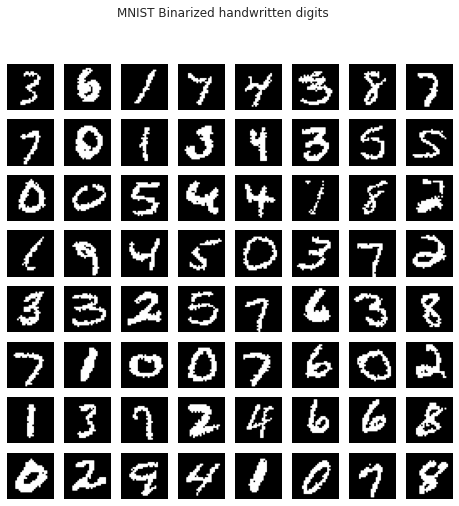

In [11]:
#same batch from dataset
fig2, axs = plt.subplots(8, 8, figsize=(8, 8))

for i, ax in enumerate(axs.flat):
    ax.imshow(images[i].view(28, 28), cmap='Greys_r')
    ax.axis('off')

plt.suptitle('MNIST Binarized handwritten digits')
plt.show()

## Classification from latent features
ok results for linear model, ok for Neaural Network

#### Linear method from sklearn

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import PredefinedSplit

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

x_train, y_train, x_test, y_test = get_mnist(semi_supervised="all")

m1.cpu().eval()

_ , _ , z_train , _  = m1(x_train)
z_train = z_train.detach().numpy()
y_train = y_train.numpy()

_ , _ , z_test , _  = m1(x_test)
z_test = z_test.detach().numpy()
y_test = y_test.numpy()

print(z_train.shape, z_test.shape)

Z = np.concatenate((z_train,z_test))
Y = np.concatenate((y_train,y_test))

#This is what you need
train_index =[-1]*len(z_train)
test_index =[0]*len(z_test)
test_fold = train_index+test_index
ps = PredefinedSplit(test_fold) #refit=false in case

(100, 10) (10000, 10)


In [13]:
# svm_classifier.get_params().keys()
##SVM
C = [0.0001, 0.0005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
svm_param = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': C },
             {'kernel': ['linear'], 'C': C }]

svm_classifier = GridSearchCV(SVC(),
                              svm_param,
                              scoring="accuracy",
                              cv=ps,
                              return_train_score=True,
                              refit=False,
                              n_jobs=-1)

svm_classifier.fit(Z,Y)
print(svm_classifier.best_params_)
pd.DataFrame(svm_classifier.cv_results_).sort_values("rank_test_score").head(30)

{'C': 50, 'gamma': 0.001, 'kernel': 'rbf'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
26,0.001783,0.0,0.034657,0.0,50,0.001,rbf,"{'C': 50, 'gamma': 0.001, 'kernel': 'rbf'}",0.8209,0.8209,0.0,1,0.99,0.99,0.0
38,0.001642,0.0,0.023439,0.0,0.1,NaN,linear,"{'C': 0.1, 'kernel': 'linear'}",0.8189,0.8189,0.0,2,0.99,0.99,0.0
37,0.001496,0.0,0.023492,0.0,0.05,NaN,linear,"{'C': 0.05, 'kernel': 'linear'}",0.8136,0.8136,0.0,3,0.93,0.93,0.0
28,0.001940,0.0,0.033451,0.0,100,0.001,rbf,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.8034,0.8034,0.0,4,1.00,1.00,0.0
39,0.001920,0.0,0.021423,0.0,0.5,NaN,linear,"{'C': 0.5, 'kernel': 'linear'}",0.7807,0.7807,0.0,5,1.00,1.00,0.0
40,0.001811,0.0,0.021827,0.0,1,NaN,linear,"{'C': 1, 'kernel': 'linear'}",0.7790,0.7790,0.0,6,1.00,1.00,0.0
44,0.001702,0.0,0.018331,0.0,100,NaN,linear,"{'C': 100, 'kernel': 'linear'}",0.7768,0.7768,0.0,7,1.00,1.00,0.0
42,0.001809,0.0,0.020782,0.0,10,NaN,linear,"{'C': 10, 'kernel': 'linear'}",0.7768,0.7768,0.0,7,1.00,1.00,0.0
41,0.001884,0.0,0.022634,0.0,5,NaN,linear,"{'C': 5, 'kernel': 'linear'}",0.7768,0.7768,0.0,7,1.00,1.00,0.0
43,0.001755,0.0,0.022147,0.0,50,NaN,linear,"{'C': 50, 'kernel': 'linear'}",0.7768,0.7768,0.0,7,1.00,1.00,0.0


In [14]:
if len(svm_classifier.best_params_)== 2:
        svc = SVC(C = svm_classifier.best_params_["C"], kernel=svm_classifier.best_params_["kernel"]).fit(z_train,y_train)
elif len(svm_classifier.best_params_)== 3:
    svc = SVC(C = svm_classifier.best_params_["C"], kernel=svm_classifier.best_params_["kernel"], gamma = svm_classifier.best_params_["gamma"]).fit(z_train,y_train)

print(accuracy_score(svc.predict(z_test),y_test))
print(classification_report(svc.predict(z_test),y_test))
print(confusion_matrix(svc.predict(z_test),y_test))

0.8209
              precision    recall  f1-score   support

           0       0.92      0.85      0.89      1061
           1       0.91      0.84      0.87      1223
           2       0.86      0.77      0.81      1155
           3       0.85      0.69      0.77      1238
           4       0.86      0.87      0.87       978
           5       0.74      0.77      0.76       861
           6       0.86      0.95      0.90       867
           7       0.72      0.91      0.80       809
           8       0.71      0.79      0.75       872
           9       0.76      0.82      0.79       936

    accuracy                           0.82     10000
   macro avg       0.82      0.83      0.82     10000
weighted avg       0.83      0.82      0.82     10000

[[ 905    0   18   16    8   24   37   13   12   28]
 [   0 1028   39   12   33    4   21   49   21   16]
 [  11   59  886   19    4    4   26  100   33   13]
 [  21    2   49  860    5  140    0    3  131   27]
 [   3    0    6    0 

In [15]:
##Logistic
l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
logistic_param = [{"penalty":["l2"], "C":C},
                  {"penalty":["l1"], "C":C},
                   {"penalty":["elasticnet"], "C":C, "l1_ratio":l1_ratio}]

logistic_classifier = GridSearchCV(LogisticRegression(solver="saga"),
                              logistic_param,
                              scoring="accuracy",
                              cv=ps,
                              return_train_score=True,
                              refit=False,
                              n_jobs=-1)

logistic_classifier.fit(Z,Y)
print(logistic_classifier.best_params_)
pd.DataFrame(logistic_classifier.cv_results_).sort_values("rank_test_score").head(30)

{'C': 0.5, 'l1_ratio': 0.1, 'penalty': 'elasticnet'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_l1_ratio,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
111,0.006967,0.0,0.001243,0.0,0.5,elasticnet,0.1,"{'C': 0.5, 'l1_ratio': 0.1, 'penalty': 'elasti...",0.7996,0.7996,0.0,1,0.98,0.98,0.0
9,0.006407,0.0,0.001390,0.0,0.5,l2,NaN,"{'C': 0.5, 'penalty': 'l2'}",0.7980,0.7980,0.0,2,0.98,0.98,0.0
112,0.011628,0.0,0.001318,0.0,0.5,elasticnet,0.2,"{'C': 0.5, 'l1_ratio': 0.2, 'penalty': 'elasti...",0.7980,0.7980,0.0,2,0.97,0.97,0.0
113,0.009529,0.0,0.001279,0.0,0.5,elasticnet,0.3,"{'C': 0.5, 'l1_ratio': 0.3, 'penalty': 'elasti...",0.7974,0.7974,0.0,4,0.97,0.97,0.0
8,0.003426,0.0,0.001558,0.0,0.1,l2,NaN,"{'C': 0.1, 'penalty': 'l2'}",0.7966,0.7966,0.0,5,0.95,0.95,0.0
114,0.010575,0.0,0.001437,0.0,0.5,elasticnet,0.4,"{'C': 0.5, 'l1_ratio': 0.4, 'penalty': 'elasti...",0.7966,0.7966,0.0,5,0.97,0.97,0.0
117,0.008541,0.0,0.001325,0.0,0.5,elasticnet,0.7,"{'C': 0.5, 'l1_ratio': 0.7, 'penalty': 'elasti...",0.7957,0.7957,0.0,7,0.97,0.97,0.0
102,0.004035,0.0,0.001369,0.0,0.1,elasticnet,0.1,"{'C': 0.1, 'l1_ratio': 0.1, 'penalty': 'elasti...",0.7953,0.7953,0.0,8,0.95,0.95,0.0
116,0.009237,0.0,0.001079,0.0,0.5,elasticnet,0.6,"{'C': 0.5, 'l1_ratio': 0.6, 'penalty': 'elasti...",0.7952,0.7952,0.0,9,0.97,0.97,0.0
115,0.007696,0.0,0.000983,0.0,0.5,elasticnet,0.5,"{'C': 0.5, 'l1_ratio': 0.5, 'penalty': 'elasti...",0.7952,0.7952,0.0,9,0.97,0.97,0.0


In [16]:
if len(logistic_classifier.best_params_) == 2:
    logistic_regression = LogisticRegression(solver="saga", C = logistic_classifier.best_params_["C"], penalty=logistic_classifier.best_params_["penalty"]).fit(z_train,y_train)#if not elastic net
elif len(logistic_classifier.best_params_) == 3:
    logistic_regression = LogisticRegression(solver="saga", C = logistic_classifier.best_params_["C"], penalty=logistic_classifier.best_params_["penalty"], l1_ratio= logistic_classifier.best_params_["l1_ratio"]).fit(z_train,y_train)#if elastic net
print(accuracy_score(logistic_regression.predict(z_test),y_test))
print(classification_report(logistic_regression.predict(z_test),y_test))
print(confusion_matrix(logistic_regression.predict(z_test),y_test))

0.7994
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       953
           1       0.88      0.89      0.89      1126
           2       0.88      0.66      0.76      1359
           3       0.85      0.69      0.76      1251
           4       0.88      0.82      0.85      1051
           5       0.72      0.75      0.74       856
           6       0.80      0.93      0.86       830
           7       0.77      0.88      0.82       902
           8       0.66      0.76      0.71       844
           9       0.65      0.79      0.71       828

    accuracy                           0.80     10000
   macro avg       0.80      0.81      0.80     10000
weighted avg       0.81      0.80      0.80     10000

[[ 864    0    6   11    1   15   22    1   11   22]
 [   0 1002   22    5   30    2    7   21    8   29]
 [  51   91  903   37   11   18   60  115   46   27]
 [  19    2   56  861    5  129    5    9  129   36]
 [   0    4   10    0 

In [17]:
#KNN
KNN_param = {"n_neighbors":list(range(1,30,2))}

KNN_classifier = GridSearchCV(KNeighborsClassifier(),
                              KNN_param,
                              scoring="accuracy",
                              cv=ps,
                              return_train_score=True,
                              refit=False,
                              n_jobs=-1)

KNN_classifier.fit(Z,Y)
print(KNN_classifier.best_params_)
pd.DataFrame(KNN_classifier.cv_results_).sort_values("rank_test_score").head(30)

{'n_neighbors': 5}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
2,0.000674,0.0,0.499020,0.0,5,{'n_neighbors': 5},0.7330,0.7330,0.0,1,0.83,0.83,0.0
3,0.000685,0.0,0.458077,0.0,7,{'n_neighbors': 7},0.7290,0.7290,0.0,2,0.80,0.80,0.0
5,0.000832,0.0,0.494585,0.0,11,{'n_neighbors': 11},0.7247,0.7247,0.0,3,0.77,0.77,0.0
4,0.000683,0.0,0.417064,0.0,9,{'n_neighbors': 9},0.7235,0.7235,0.0,4,0.79,0.79,0.0
6,0.000807,0.0,0.471166,0.0,13,{'n_neighbors': 13},0.7189,0.7189,0.0,5,0.76,0.76,0.0
7,0.000689,0.0,0.445320,0.0,15,{'n_neighbors': 15},0.7184,0.7184,0.0,6,0.81,0.81,0.0
0,0.000589,0.0,0.409901,0.0,1,{'n_neighbors': 1},0.7159,0.7159,0.0,7,1.00,1.00,0.0
8,0.000761,0.0,0.404827,0.0,17,{'n_neighbors': 17},0.7146,0.7146,0.0,8,0.78,0.78,0.0
9,0.000752,0.0,0.392486,0.0,19,{'n_neighbors': 19},0.7109,0.7109,0.0,9,0.74,0.74,0.0
1,0.000801,0.0,0.448315,0.0,3,{'n_neighbors': 3},0.7108,0.7108,0.0,10,0.84,0.84,0.0


In [18]:
KNN = KNeighborsClassifier(n_neighbors=KNN_classifier.best_params_["n_neighbors"]).fit(z_train,y_train)
print(accuracy_score(KNN.predict(z_test),y_test))
print(classification_report(KNN.predict(z_test),y_test))
print(confusion_matrix(KNN.predict(z_test),y_test))

0.733
              precision    recall  f1-score   support

           0       0.93      0.59      0.73      1542
           1       0.89      0.75      0.81      1345
           2       0.71      0.85      0.77       861
           3       0.90      0.67      0.76      1359
           4       0.76      0.79      0.78       948
           5       0.58      0.86      0.69       603
           6       0.69      0.87      0.77       766
           7       0.72      0.74      0.73       999
           8       0.67      0.67      0.67       965
           9       0.44      0.73      0.55       612

    accuracy                           0.73     10000
   macro avg       0.73      0.75      0.73     10000
weighted avg       0.77      0.73      0.74     10000

[[ 916    9   61   43   25   97  182   70   46   93]
 [   1 1010   87   13   55   17   33   63   30   36]
 [   6   15  732    7   10    2   21   55   10    3]
 [  21    9   50  904    7  179    5   15  145   24]
 [   4    5    4    0  

#### Training Neural Network on top of Z

In [19]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from models import FFNN


m1.cuda().eval()


labelled_loader, _, test_loader = get_mnist(batch_size=25,semi_supervised="dataloader")

class Classifier_latentspace_M1(FFNN):
    def __init__(self,layers,num_classes):
        super().__init__(layers,num_classes)        

    def forward(self, x):
        x = self.net(x)
        return F.log_softmax(x, dim=1)

layer_classifier = [latent_f,60]
num_classes = 10
net_classifier = Classifier_latentspace_M1(layer_classifier, num_classes)
init_weights(net_classifier)
net_classifier.cuda()

Classifier_latentspace_M1(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=10, bias=True)
  )
)

In [20]:
## net training-evaluation
criterion = nn.CrossEntropyLoss()  # Your code here!
optimizer = torch.optim.Adam(net_classifier.parameters(), lr=0.001)

num_epoch = 100  # Your code here!
train_acc = []
val_acc = []
diff_acc=[100.]
for epoch in range(num_epoch):  # loop over the dataset multiple times
    net_classifier.train()
    running_loss = 0.0
    losses = []
    for i, data in enumerate(labelled_loader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = inputs.cuda(),labels.cuda()
        _,_,inputs,_ = m1(inputs)
        inputs.detach().cuda()
        output = net_classifier(inputs)

        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss
    
    losses.append(running_loss / i)
    
    ### Evaluate validation
    net_classifier.eval()
    correct_v = 0
    total_v = 0
    for i_v, data_v in enumerate(test_loader, 0):
         
        # get the inputs
        inputs_v, labels_v = data_v

        # wrap them in Variable
        inputs_v, labels_v = inputs_v.cuda(), labels_v.cuda()
        _,_,inputs_v,_ = m1(inputs_v)
        inputs_v.detach().cuda()
        
        output_v = net_classifier(inputs_v)
        _, predicted_v = torch.max(output_v.data, 1)
        total_v += labels_v.size(0)
        correct_v += (predicted_v == labels_v).sum()

    val_acc.append(100 * correct_v.true_divide(total_v))

    # early stopping
    if len(val_acc)>=2:
        diff_acc.append(np.round(val_acc[-1].cpu() - val_acc[-2].cpu(),4))
        
        
    
    print("Epoch %2i : Train Loss %f , Valid acc %f, Rounded incremental learning %f" % (
        epoch+1, losses[-1], val_acc[-1],diff_acc[-1]))
    
    #if for 3 consecutive step the result is worse or doesn't improve enough stop
    try:
        if diff_acc[-1]<0.001 and diff_acc[-2]<0.001 and diff_acc[-3]<0.001:
            
            print("Early stopping reached")
            break
    except: 
        pass
   

print('Finished Training')

Epoch  1 : Train Loss 3.076064 , Valid acc 17.279999, Rounded incremental learning 100.000000
Epoch  2 : Train Loss 3.024247 , Valid acc 19.039999, Rounded incremental learning 1.760000
Epoch  3 : Train Loss 2.975416 , Valid acc 21.409998, Rounded incremental learning 2.370000
Epoch  4 : Train Loss 2.920732 , Valid acc 23.510000, Rounded incremental learning 2.100000
Epoch  5 : Train Loss 2.868768 , Valid acc 26.000000, Rounded incremental learning 2.490000
Epoch  6 : Train Loss 2.823723 , Valid acc 27.950001, Rounded incremental learning 1.950000
Epoch  7 : Train Loss 2.767778 , Valid acc 30.689999, Rounded incremental learning 2.740000
Epoch  8 : Train Loss 2.732578 , Valid acc 33.429996, Rounded incremental learning 2.740000
Epoch  9 : Train Loss 2.667754 , Valid acc 37.559998, Rounded incremental learning 4.130000
Epoch 10 : Train Loss 2.613471 , Valid acc 41.090000, Rounded incremental learning 3.530000
Epoch 11 : Train Loss 2.573746 , Valid acc 44.709999, Rounded incremental lear

In [22]:
m1.cpu().eval()
net_classifier.eval().cpu()

_, test_set_class = get_mnist(batch_size=10000)
x_test, y_test = next(iter(test_set_class))
x_test, y_test = x_test.cpu(), y_test.cpu()
_,_, z_test,_ = m1(x_test)
output_clasifier = net_classifier(z_test)
_, y_predict = torch.max(output_clasifier.data, 1)

y_predict = y_predict.detach().cpu().numpy()



print(accuracy_score(y_predict,y_test))
print(classification_report(y_predict,y_test))
print(confusion_matrix(y_predict,y_test))

0.7946
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       909
           1       0.95      0.84      0.89      1285
           2       0.75      0.90      0.82       856
           3       0.81      0.82      0.82       997
           4       0.86      0.82      0.84      1032
           5       0.67      0.69      0.68       869
           6       0.90      0.83      0.86      1043
           7       0.78      0.74      0.76      1082
           8       0.79      0.75      0.77      1029
           9       0.62      0.70      0.66       898

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.80      0.79      0.80     10000

[[ 778    0   28   12    0   42   31    5    8    5]
 [   0 1074   45    2   31    6    8   59    9   51]
 [   0   21  771   14    3    2    4   28    8    5]
 [   7    4   19  822    0   98    0    3   33   11]
 [   0    2   26    0 

# **5. Semi-Supervised VAE (M2)** <a class="anchor" id="chapter5"></a>
We will now implement the M2 model from Semi-Supervised Learning with Deep Generative
Models. This requires training a new VAE where we use different objectives for the labeled and
unlabeled data examples.
1. Implement an M2 VAE model.

In [4]:
from utils import get_mnist
import torch
labelled, unlabelled, test_set = get_mnist(semi_supervised="dataloader", batch_size=64)

In [14]:
from models import M2
from utils import training_M2, test_M2, init_weights

latent_f = 50
num_classes=10
num_features = 784
layers_enc = [num_features,500,500] ##Adding extra layer
layers_dec = [latent_f+num_classes, 500, 500]
layer_class = [num_features,128]


m2 = M2(layers_enc,layers_dec,latent_f,num_features, 1.0, #VAE
        layer_class, num_classes=10, #classifier
        activation="ReLU", batchnorm=False, dropout=None,dropout_classifier=0.2) #extra VAE
        # activation_classifier="LeakyReLU", batchnorm_classifier=True, 9) #extra classifier

init_weights(m2)
optimizer = torch.optim.Adam(m2.parameters(), lr = 1e-4)
print(m2)

M2(
  (classifier): Classifier(
    (net): Sequential(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): ReLU()
      (2): Linear(in_features=500, out_features=10, bias=True)
    )
  )
  (encoder): Encoder(
    (net): Sequential(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): ReLU()
      (2): Linear(in_features=500, out_features=500, bias=True)
      (3): ReLU()
    )
  )
  (mu_dense): Linear(in_features=500, out_features=50, bias=True)
  (log_var_dense): Linear(in_features=500, out_features=50, bias=True)
  (decoder): Decoder(
    (net): Sequential(
      (0): Linear(in_features=60, out_features=500, bias=True)
      (1): ReLU()
      (2): Linear(in_features=500, out_features=500, bias=True)
      (3): ReLU()
      (4): Linear(in_features=500, out_features=784, bias=True)
    )
  )
)


In [15]:
from collections import defaultdict
ALPHA=50
LR = 3e-4
epoch = 0
EPOCH = 50 # or use 200
optimizer = torch.optim.Adam(m2.parameters(), lr=LR)#, weight_decay=0.8
cuda = torch.cuda.is_available()
# cuda = False
print("Cuda is available :", cuda)

training_data = defaultdict(list)
training_data_labelled = defaultdict(list)
training_data_unlabelled = defaultdict(list)
test_data = defaultdict(list)

while epoch < EPOCH:
    epoch+= 1
    print("\nepoch : ", epoch)
    training_M2(m2, labelled, unlabelled, optimizer, ALPHA, cuda, training_data, training_data_labelled, training_data_unlabelled)
    test_M2(m2, test_set, ALPHA, cuda, test_data)

Cuda is available : True

epoch :  1
Trainig :
Labelled, elbo(L) : -206.806, BCE : -201.09, KL : 3.413
Unlabelled; elbo(U) : -207.008, BCE : -201.678, KL : 3.0276, H : 1.298
Total loss : 421.89, Classifier loss : 1.159, Classifier accuracy : 99.24
Test :
Tot loss : 440.322, Classifier loss : 1.897, Classifier accuracy : 72.44

epoch :  2
Trainig :
Labelled, elbo(L) : -186.072, BCE : -177.28, KL : 6.4893
Unlabelled; elbo(U) : -191.315, BCE : -183.291, KL : 5.7222, H : 1.171
Total loss : 380.631, Classifier loss : 1.06, Classifier accuracy : 100.0
Test :
Tot loss : 419.799, Classifier loss : 1.913, Classifier accuracy : 71.03

epoch :  3
Trainig :
Labelled, elbo(L) : -170.366, BCE : -159.065, KL : 8.9983
Unlabelled; elbo(U) : -182.815, BCE : -172.912, KL : 7.6006, H : 1.187
Total loss : 356.387, Classifier loss : 1.06, Classifier accuracy : 100.0
Test :
Tot loss : 407.079, Classifier loss : 1.909, Classifier accuracy : 71.98

epoch :  4
Trainig :
Labelled, elbo(L) : -168.463, BCE : -156.

KeyboardInterrupt: 

Look, test loss increase, the model is overfitting, the accuracy increase, so it is probably overfitting 1/2 classes

in the first the net sees the labelled data 450 times and the accuracy is 70%, at the second epoch instead the labelled data is seen 900 times and the acc drops already

In the next training the labelled data is processed once every epoch, that mean that the learning will be super-slow (I think)

In [16]:
m2.cpu().eval()
fig, axs = plt.subplots(10, 10, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    images = m2.conditional_sample(y=i%10, n=10)
    ax.imshow(images[i%10].detach().view(28, 28), cmap='Greys_r')
    ax.axis('off')

plt.suptitle('Conditional generation')

NameError: name 'plt' is not defined

In [18]:
from utils import training_M2_v2
from collections import defaultdict
m2_v2 = M2(layers_enc,layers_dec,latent_f,num_features, 1.0, #VAE
        layer_class, num_classes=10, #classifier
        activation="ReLU", batchnorm=False, dropout=None,dropout_classifier=0.2) #extra VAE
        # activation_classifier="LeakyReLU", batchnorm_classifier=True, 9) 
ALPHA=50
LR = 3e-4
epoch = 0
EPOCH = 100 # or use 200
optimizer = torch.optim.Adam(m2_v2.parameters(), lr=LR)
cuda = torch.cuda.is_available()
# cuda = False
print("Cuda is available :", cuda)

training_data = defaultdict(list)
training_data_labelled = defaultdict(list)
training_data_unlabelled = defaultdict(list)
test_data = defaultdict(list)

while epoch < EPOCH:
    epoch+= 1
    print("\nepoch : ", epoch)
    training_M2_v2(m2_v2, labelled, unlabelled, optimizer, ALPHA, cuda, training_data, training_data_labelled, training_data_unlabelled)
    test_M2(m2_v2, test_set, ALPHA, cuda, test_data)

Cuda is available : True

epoch :  1
Trainig :
Labelled, elbo(L) : -365.79, BCE : -360.159, KL : 3.3291
Unlabelled; elbo(U) : -187.259, BCE : -177.438, KL : 7.5189, H : 2.205
Total loss : 185.686, Classifier loss : 2.316, Classifier accuracy : 13.28
Test :
Tot loss : 416.844, Classifier loss : 3.2, Classifier accuracy : 22.53

epoch :  2
Trainig :
Labelled, elbo(L) : -151.263, BCE : -133.67, KL : 15.2904
Unlabelled; elbo(U) : -139.126, BCE : -121.213, KL : 15.6107, H : 1.926
Total loss : 137.412, Classifier loss : 1.708, Classifier accuracy : 40.62
Test :
Tot loss : 357.039, Classifier loss : 2.924, Classifier accuracy : 32.71

epoch :  3
Trainig :
Labelled, elbo(L) : -136.829, BCE : -117.272, KL : 17.2539
Unlabelled; elbo(U) : -122.388, BCE : -102.69, KL : 17.3957, H : 1.822
Total loss : 120.759, Classifier loss : 1.488, Classifier accuracy : 47.66
Test :
Tot loss : 341.008, Classifier loss : 2.872, Classifier accuracy : 34.76

epoch :  4
Trainig :
Labelled, elbo(L) : -133.566, BCE : 

KeyboardInterrupt: 

Now is it overfitting the unlabelled dataset, but same result as before

# Extra: Classification from raw data
Using 100 labels



#### Linear method from sklearn

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import PredefinedSplit

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

x_train, y_train, x_test, y_test = get_mnist(semi_supervised="all")

#Prepare train-test set
x_train, y_train = x_train.numpy(), y_train.numpy()
x_test,y_test = x_test.numpy(), y_test.numpy()
print(x_train.shape, x_test.shape)

X = np.concatenate((x_train,x_test))
Y = np.concatenate((y_train,y_test))

#This is what you need
train_index =[-1]*len(x_train)
test_index =[0]*len(x_test)
test_fold = train_index+test_index
ps = PredefinedSplit(test_fold) #refit=false in case


(100, 784) (10000, 784)


In [24]:
# svm_classifier.get_params().keys()
##SVM
C = [0.0001, 0.0005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
svm_param = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': C },
             {'kernel': ['linear'], 'C': C }]

svm_classifier = GridSearchCV(SVC(),
                              svm_param,
                              scoring="accuracy",
                              cv=ps,
                              return_train_score=True,
                              refit=False,
                              n_jobs=-1)
svm_classifier.fit(X,Y)
print(svm_classifier.best_params_)
pd.DataFrame(svm_classifier.cv_results_).sort_values("rank_test_score").head(30)

{'C': 50, 'gamma': 0.001, 'kernel': 'rbf'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
28,0.025195,0.0,0.885397,0.0,100,0.001,rbf,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.7706,0.7706,0.0,1,1.00,1.00,0.0
26,0.030854,0.0,0.870649,0.0,50,0.001,rbf,"{'C': 50, 'gamma': 0.001, 'kernel': 'rbf'}",0.7706,0.7706,0.0,1,1.00,1.00,0.0
44,0.019677,0.0,0.703704,0.0,100,NaN,linear,"{'C': 100, 'kernel': 'linear'}",0.7661,0.7661,0.0,3,1.00,1.00,0.0
42,0.019610,0.0,0.716789,0.0,10,NaN,linear,"{'C': 10, 'kernel': 'linear'}",0.7661,0.7661,0.0,3,1.00,1.00,0.0
41,0.020501,0.0,0.781800,0.0,5,NaN,linear,"{'C': 5, 'kernel': 'linear'}",0.7661,0.7661,0.0,3,1.00,1.00,0.0
40,0.023088,0.0,0.777305,0.0,1,NaN,linear,"{'C': 1, 'kernel': 'linear'}",0.7661,0.7661,0.0,3,1.00,1.00,0.0
39,0.019621,0.0,0.764018,0.0,0.5,NaN,linear,"{'C': 0.5, 'kernel': 'linear'}",0.7661,0.7661,0.0,3,1.00,1.00,0.0
38,0.022165,0.0,0.845505,0.0,0.1,NaN,linear,"{'C': 0.1, 'kernel': 'linear'}",0.7661,0.7661,0.0,3,1.00,1.00,0.0
37,0.019718,0.0,0.731771,0.0,0.05,NaN,linear,"{'C': 0.05, 'kernel': 'linear'}",0.7661,0.7661,0.0,3,1.00,1.00,0.0
43,0.022486,0.0,0.727438,0.0,50,NaN,linear,"{'C': 50, 'kernel': 'linear'}",0.7661,0.7661,0.0,3,1.00,1.00,0.0


In [25]:
if len(svm_classifier.best_params_)== 2:
        svc = SVC(C = svm_classifier.best_params_["C"], kernel=svm_classifier.best_params_["kernel"]).fit(x_train,y_train)
elif len(svm_classifier.best_params_)== 3:
    svc = SVC(C = svm_classifier.best_params_["C"], kernel=svm_classifier.best_params_["kernel"], gamma = svm_classifier.best_params_["gamma"]).fit(x_train,y_train)
print(accuracy_score(svc.predict(x_test),y_test))
print(classification_report(svc.predict(x_test),y_test))
print(confusion_matrix(svc.predict(x_test),y_test))

0.7706
              precision    recall  f1-score   support

           0       0.90      0.85      0.88      1038
           1       0.96      0.84      0.90      1294
           2       0.77      0.81      0.79       976
           3       0.81      0.74      0.78      1103
           4       0.78      0.73      0.76      1051
           5       0.69      0.69      0.69       897
           6       0.83      0.84      0.83       942
           7       0.60      0.84      0.70       735
           8       0.58      0.79      0.67       716
           9       0.74      0.60      0.66      1248

    accuracy                           0.77     10000
   macro avg       0.77      0.78      0.77     10000
weighted avg       0.78      0.77      0.77     10000

[[ 886    0   17    5    4   33   46   17   15   15]
 [   3 1089   32   21   16   20   12   45   38   18]
 [   7    2  794   50    2   16   44   12   44    5]
 [   3    2   19  820    0  108    2    8  123   18]
 [   2    0   22    1 

In [26]:
##Logistic
l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
logistic_param = [{"penalty":["l2"], "C":C},
                  {"penalty":["l1"], "C":C},
                   {"penalty":["elasticnet"], "C":C, "l1_ratio":l1_ratio}]

logistic_classifier = GridSearchCV(LogisticRegression(solver="saga"),
                              logistic_param,
                              scoring="accuracy",
                              cv=ps,
                              return_train_score=True,
                              refit=False,
                              n_jobs=-1)

logistic_classifier.fit(X,Y)
print(logistic_classifier.best_params_)
pd.DataFrame(logistic_classifier.cv_results_).sort_values("rank_test_score").head(30)

{'C': 0.1, 'penalty': 'l2'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_l1_ratio,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
8,0.693670,0.0,0.011418,0.0,0.1,l2,NaN,"{'C': 0.1, 'penalty': 'l2'}",0.7567,0.7567,0.0,1,1.0,1.0,0.0
7,0.628376,0.0,0.051945,0.0,0.05,l2,NaN,"{'C': 0.05, 'penalty': 'l2'}",0.7555,0.7555,0.0,2,1.0,1.0,0.0
9,0.682241,0.0,0.011795,0.0,0.5,l2,NaN,"{'C': 0.5, 'penalty': 'l2'}",0.7546,0.7546,0.0,3,1.0,1.0,0.0
11,0.681622,0.0,0.013684,0.0,5,l2,NaN,"{'C': 5, 'penalty': 'l2'}",0.7545,0.7545,0.0,4,1.0,1.0,0.0
129,1.181267,0.0,0.012458,0.0,5,elasticnet,0.1,"{'C': 5, 'l1_ratio': 0.1, 'penalty': 'elasticn...",0.7540,0.7540,0.0,5,1.0,1.0,0.0
148,1.288360,0.0,0.012509,0.0,50,elasticnet,0.2,"{'C': 50, 'l1_ratio': 0.2, 'penalty': 'elastic...",0.7540,0.7540,0.0,5,1.0,1.0,0.0
149,1.312323,0.0,0.013215,0.0,50,elasticnet,0.3,"{'C': 50, 'l1_ratio': 0.3, 'penalty': 'elastic...",0.7539,0.7539,0.0,7,1.0,1.0,0.0
161,1.152231,0.0,0.029113,0.0,100,elasticnet,0.6,"{'C': 100, 'l1_ratio': 0.6, 'penalty': 'elasti...",0.7539,0.7539,0.0,7,1.0,1.0,0.0
156,1.116248,0.0,0.011782,0.0,100,elasticnet,0.1,"{'C': 100, 'l1_ratio': 0.1, 'penalty': 'elasti...",0.7536,0.7536,0.0,9,1.0,1.0,0.0
147,1.118045,0.0,0.011115,0.0,50,elasticnet,0.1,"{'C': 50, 'l1_ratio': 0.1, 'penalty': 'elastic...",0.7533,0.7533,0.0,10,1.0,1.0,0.0


In [30]:
if len(logistic_classifier.best_params_) == 2:
    logistic_regression = LogisticRegression(solver="saga", C = logistic_classifier.best_params_["C"], penalty=logistic_classifier.best_params_["penalty"]).fit(x_train,y_train)#if not elastic net
elif len(logistic_classifier.best_params_) == 3:
    logistic_regression = LogisticRegression(solver="saga", C = logistic_classifier.best_params_["C"], penalty=logistic_classifier.best_params_["penalty"], l1_ratio= logistic_classifier.best_params_["l1_ratio"]).fit(x_train,y_train)#if elastic net


print(accuracy_score(logistic_regression.predict(x_test),y_test))
print(classification_report(logistic_regression.predict(x_test),y_test))
print(confusion_matrix(logistic_regression.predict(x_test),y_test))

0.7571
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1133
           1       0.96      0.86      0.91      1266
           2       0.72      0.86      0.78       859
           3       0.85      0.70      0.77      1232
           4       0.71      0.71      0.71       971
           5       0.57      0.69      0.62       741
           6       0.82      0.82      0.82       960
           7       0.65      0.83      0.73       806
           8       0.60      0.75      0.67       789
           9       0.72      0.58      0.64      1243

    accuracy                           0.76     10000
   macro avg       0.75      0.76      0.75     10000
weighted avg       0.77      0.76      0.76     10000

[[ 911    0   30   17    7   56   52   31   11   18]
 [   1 1088   44    6   16   16    7   37   41   10]
 [   2    2  740   23    5   12   31   10   26    8]
 [   4    4   31  859    6  135    2    9  148   34]
 [   0    0   20    1 

In [31]:
#KNN 
KNN_param = {"n_neighbors":list(range(1,30,2))}

KNN_classifier = GridSearchCV(KNeighborsClassifier(),
                              KNN_param,
                              scoring="accuracy",
                              cv=ps,
                              return_train_score=True,
                              refit=False,
                              n_jobs=-1)

KNN_classifier.fit(X,Y)
print(KNN_classifier.best_params_)
pd.DataFrame(KNN_classifier.cv_results_).sort_values("rank_test_score").head(30)

{'n_neighbors': 1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,0.019017,0.0,1.547730,0.0,1,{'n_neighbors': 1},0.7060,0.7060,0.0,1,1.00,1.00,0.0
1,0.016707,0.0,1.524001,0.0,3,{'n_neighbors': 3},0.6359,0.6359,0.0,2,0.76,0.76,0.0
2,0.020674,0.0,1.457602,0.0,5,{'n_neighbors': 5},0.6130,0.6130,0.0,3,0.71,0.71,0.0
3,0.017645,0.0,1.566732,0.0,7,{'n_neighbors': 7},0.5742,0.5742,0.0,4,0.67,0.67,0.0
4,0.016439,0.0,1.461839,0.0,9,{'n_neighbors': 9},0.5520,0.5520,0.0,5,0.63,0.63,0.0
5,0.012440,0.0,1.619983,0.0,11,{'n_neighbors': 11},0.5296,0.5296,0.0,6,0.55,0.55,0.0
6,0.011569,0.0,1.442066,0.0,13,{'n_neighbors': 13},0.5169,0.5169,0.0,7,0.57,0.57,0.0
7,0.033151,0.0,1.565659,0.0,15,{'n_neighbors': 15},0.4984,0.4984,0.0,8,0.53,0.53,0.0
8,0.011199,0.0,1.354255,0.0,17,{'n_neighbors': 17},0.4897,0.4897,0.0,9,0.53,0.53,0.0
9,0.015996,0.0,1.412070,0.0,19,{'n_neighbors': 19},0.4722,0.4722,0.0,10,0.53,0.53,0.0


In [32]:
KNN = KNeighborsClassifier(n_neighbors=KNN_classifier.best_params_["n_neighbors"]).fit(x_train,y_train)
print(accuracy_score(KNN.predict(x_test),y_test))
print(classification_report(KNN.predict(x_test),y_test))
print(confusion_matrix(KNN.predict(x_test),y_test))

0.706
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       932
           1       0.99      0.56      0.72      2015
           2       0.52      0.88      0.65       608
           3       0.69      0.68      0.69      1026
           4       0.61      0.67      0.64       904
           5       0.64      0.68      0.66       844
           6       0.85      0.86      0.86       953
           7       0.71      0.76      0.73       957
           8       0.43      0.82      0.56       511
           9       0.72      0.58      0.64      1250

    accuracy                           0.71     10000
   macro avg       0.70      0.74      0.70     10000
weighted avg       0.75      0.71      0.71     10000

[[ 837    0   19    7    0   12   33    4   12    8]
 [  30 1127  233  144   65   87   42  110  134   43]
 [   4    1  534   22    1    5   12    0   28    1]
 [   4    1   54  700    2   74    2    3  167   19]
 [  11    0   26    2  

# Extra: Classification from PCA
Using 100 labels

In [40]:
from sklearn.decomposition import PCA
x_train, y_train, x_test, y_test = get_mnist(semi_supervised="all")

#Prepare train-test set
x_train, y_train = x_train.numpy(), y_train.numpy()
x_test,y_test = x_test.numpy(), y_test.numpy()


pca = PCA(n_components=10)#same number as z
pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

print(x_train.shape, x_test.shape)

X = np.concatenate((x_train,x_test))
Y = np.concatenate((y_train,y_test))



#This is what you need
train_index =[-1]*len(x_train)
test_index =[0]*len(x_test)
test_fold = train_index+test_index
ps = PredefinedSplit(test_fold) #refit=false in case

(100, 10) (10000, 10)


In [41]:
# svm_classifier.get_params().keys()
##SVM
C = [0.0001, 0.0005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
svm_param = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': C },
             {'kernel': ['linear'], 'C': C }]

svm_classifier = GridSearchCV(SVC(),
                              svm_param,
                              scoring="accuracy",
                              cv=ps,
                              return_train_score=True,
                              refit=False,
                              n_jobs=-1)
svm_classifier.fit(X,Y)
print(svm_classifier.best_params_)
pd.DataFrame(svm_classifier.cv_results_).sort_values("rank_test_score").head(30)

{'C': 0.05, 'kernel': 'linear'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
37,0.001504,0.0,0.022782,0.0,0.05,NaN,linear,"{'C': 0.05, 'kernel': 'linear'}",0.6617,0.6617,0.0,1,0.88,0.88,0.0
26,0.003036,0.0,0.035233,0.0,50,0.001,rbf,"{'C': 50, 'gamma': 0.001, 'kernel': 'rbf'}",0.6585,0.6585,0.0,2,0.91,0.91,0.0
38,0.001634,0.0,0.025545,0.0,0.1,NaN,linear,"{'C': 0.1, 'kernel': 'linear'}",0.6555,0.6555,0.0,3,0.91,0.91,0.0
24,0.001589,0.0,0.042113,0.0,10,0.001,rbf,"{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",0.6548,0.6548,0.0,4,0.84,0.84,0.0
29,0.001502,0.0,0.033891,0.0,100,0.0001,rbf,"{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}",0.6516,0.6516,0.0,5,0.84,0.84,0.0
22,0.002035,0.0,0.036130,0.0,5,0.001,rbf,"{'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}",0.6499,0.6499,0.0,6,0.78,0.78,0.0
27,0.003862,0.0,0.036659,0.0,50,0.0001,rbf,"{'C': 50, 'gamma': 0.0001, 'kernel': 'rbf'}",0.6491,0.6491,0.0,7,0.80,0.80,0.0
36,0.001504,0.0,0.023299,0.0,0.01,NaN,linear,"{'C': 0.01, 'kernel': 'linear'}",0.6486,0.6486,0.0,8,0.81,0.81,0.0
28,0.001842,0.0,0.030782,0.0,100,0.001,rbf,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.6432,0.6432,0.0,9,0.95,0.95,0.0
39,0.001793,0.0,0.022204,0.0,0.5,NaN,linear,"{'C': 0.5, 'kernel': 'linear'}",0.6430,0.6430,0.0,10,0.96,0.96,0.0


In [42]:
if len(svm_classifier.best_params_)== 2:
        svc = SVC(C = svm_classifier.best_params_["C"], kernel=svm_classifier.best_params_["kernel"]).fit(x_train,y_train)
elif len(svm_classifier.best_params_)== 3:
    svc = SVC(C = svm_classifier.best_params_["C"], kernel=svm_classifier.best_params_["kernel"], gamma = svm_classifier.best_params_["gamma"]).fit(x_train,y_train)
print(accuracy_score(svc.predict(x_test),y_test))
print(classification_report(svc.predict(x_test),y_test))
print(confusion_matrix(svc.predict(x_test),y_test))

0.6617
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       863
           1       0.97      0.77      0.86      1443
           2       0.62      0.56      0.59      1142
           3       0.45      0.68      0.54       657
           4       0.53      0.62      0.57       841
           5       0.50      0.45      0.47      1003
           6       0.72      0.69      0.71       993
           7       0.74      0.80      0.77       946
           8       0.65      0.65      0.65       965
           9       0.63      0.55      0.59      1147

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.65     10000
weighted avg       0.68      0.66      0.66     10000

[[ 744    0   56    0    5   12   23    1   13    9]
 [   0 1104   32   28   23   56   13   86   65   36]
 [  11    9  644   90   51   35  163   24   85   30]
 [   9    8   28  450    4   89    8    1   51    9]
 [   4    0   52    5 

In [43]:
##Logistic
l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
logistic_param = [{"penalty":["l2"], "C":C},
                  {"penalty":["l1"], "C":C},
                   {"penalty":["elasticnet"], "C":C, "l1_ratio":l1_ratio}]

logistic_classifier = GridSearchCV(LogisticRegression(solver="saga"),
                              logistic_param,
                              scoring="accuracy",
                              cv=ps,
                              return_train_score=True,
                              refit=False,
                              n_jobs=-1)

logistic_classifier.fit(X,Y)
print(logistic_classifier.best_params_)
pd.DataFrame(logistic_classifier.cv_results_).sort_values("rank_test_score").head(30)

{'C': 0.1, 'penalty': 'l2'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_l1_ratio,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
8,0.011797,0.0,0.001489,0.0,0.1,l2,NaN,"{'C': 0.1, 'penalty': 'l2'}",0.6665,0.6665,0.0,1,0.86,0.86,0.0
7,0.004895,0.0,0.002877,0.0,0.05,l2,NaN,"{'C': 0.05, 'penalty': 'l2'}",0.6641,0.6641,0.0,2,0.81,0.81,0.0
102,0.018936,0.0,0.001416,0.0,0.1,elasticnet,0.1,"{'C': 0.1, 'l1_ratio': 0.1, 'penalty': 'elasti...",0.6607,0.6607,0.0,3,0.85,0.85,0.0
111,0.018711,0.0,0.001422,0.0,0.5,elasticnet,0.1,"{'C': 0.5, 'l1_ratio': 0.1, 'penalty': 'elasti...",0.6591,0.6591,0.0,4,0.90,0.90,0.0
113,0.016921,0.0,0.001354,0.0,0.5,elasticnet,0.3,"{'C': 0.5, 'l1_ratio': 0.3, 'penalty': 'elasti...",0.6583,0.6583,0.0,5,0.89,0.89,0.0
112,0.018724,0.0,0.001391,0.0,0.5,elasticnet,0.2,"{'C': 0.5, 'l1_ratio': 0.2, 'penalty': 'elasti...",0.6581,0.6581,0.0,6,0.90,0.90,0.0
9,0.012448,0.0,0.001282,0.0,0.5,l2,NaN,"{'C': 0.5, 'penalty': 'l2'}",0.6581,0.6581,0.0,6,0.91,0.91,0.0
115,0.019047,0.0,0.001405,0.0,0.5,elasticnet,0.5,"{'C': 0.5, 'l1_ratio': 0.5, 'penalty': 'elasti...",0.6569,0.6569,0.0,8,0.88,0.88,0.0
114,0.021179,0.0,0.002179,0.0,0.5,elasticnet,0.4,"{'C': 0.5, 'l1_ratio': 0.4, 'penalty': 'elasti...",0.6567,0.6567,0.0,9,0.88,0.88,0.0
116,0.015347,0.0,0.001347,0.0,0.5,elasticnet,0.6,"{'C': 0.5, 'l1_ratio': 0.6, 'penalty': 'elasti...",0.6543,0.6543,0.0,10,0.88,0.88,0.0


In [44]:
if len(logistic_classifier.best_params_) == 2:
    logistic_regression = LogisticRegression(solver="saga", C = logistic_classifier.best_params_["C"], penalty=logistic_classifier.best_params_["penalty"]).fit(x_train,y_train)#if not elastic net
elif len(logistic_classifier.best_params_) == 3:
    logistic_regression = LogisticRegression(solver="saga", C = logistic_classifier.best_params_["C"], penalty=logistic_classifier.best_params_["penalty"], l1_ratio= logistic_classifier.best_params_["l1_ratio"]).fit(x_train,y_train)#if elastic net


print(accuracy_score(logistic_regression.predict(x_test),y_test))
print(classification_report(logistic_regression.predict(x_test),y_test))
print(confusion_matrix(logistic_regression.predict(x_test),y_test))

0.6665
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       998
           1       0.96      0.76      0.85      1433
           2       0.62      0.67      0.64       942
           3       0.53      0.72      0.61       753
           4       0.45      0.53      0.49       836
           5       0.38      0.44      0.41       762
           6       0.74      0.76      0.75       942
           7       0.77      0.75      0.76      1058
           8       0.64      0.64      0.64       973
           9       0.68      0.53      0.60      1303

    accuracy                           0.67     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.69      0.67      0.67     10000

[[ 810    0   78    0    7   42   28    3   19   11]
 [   1 1089   27   34   27   67   11   88   58   31]
 [   9    5  635   39    3   15  103   15  108   10]
 [  11    8   34  539    9   92    5    1   33   21]
 [   3    1  104    9 

In [45]:
#KNN 
KNN_param = {"n_neighbors":list(range(1,30,2))}

KNN_classifier = GridSearchCV(KNeighborsClassifier(),
                              KNN_param,
                              scoring="accuracy",
                              cv=ps,
                              return_train_score=True,
                              refit=False,
                              n_jobs=-1)

KNN_classifier.fit(X,Y)
print(KNN_classifier.best_params_)
pd.DataFrame(KNN_classifier.cv_results_).sort_values("rank_test_score").head(30)

{'n_neighbors': 1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,0.000906,0.0,0.342403,0.0,1,{'n_neighbors': 1},0.6462,0.6462,0.0,1,1.00,1.00,0.0
2,0.000823,0.0,0.375602,0.0,5,{'n_neighbors': 5},0.6273,0.6273,0.0,2,0.83,0.83,0.0
3,0.000796,0.0,0.364065,0.0,7,{'n_neighbors': 7},0.6235,0.6235,0.0,3,0.83,0.83,0.0
1,0.000982,0.0,0.378582,0.0,3,{'n_neighbors': 3},0.6190,0.6190,0.0,4,0.88,0.88,0.0
4,0.000863,0.0,0.414226,0.0,9,{'n_neighbors': 9},0.6107,0.6107,0.0,5,0.77,0.77,0.0
5,0.000849,0.0,0.431510,0.0,11,{'n_neighbors': 11},0.6062,0.6062,0.0,6,0.75,0.75,0.0
6,0.000858,0.0,0.432301,0.0,13,{'n_neighbors': 13},0.6020,0.6020,0.0,7,0.72,0.72,0.0
7,0.000777,0.0,0.452113,0.0,15,{'n_neighbors': 15},0.5925,0.5925,0.0,8,0.69,0.69,0.0
8,0.000773,0.0,0.380941,0.0,17,{'n_neighbors': 17},0.5812,0.5812,0.0,9,0.61,0.61,0.0
9,0.000728,0.0,0.380472,0.0,19,{'n_neighbors': 19},0.5769,0.5769,0.0,10,0.64,0.64,0.0


In [46]:
KNN = KNeighborsClassifier(n_neighbors=KNN_classifier.best_params_["n_neighbors"]).fit(x_train,y_train)
print(accuracy_score(KNN.predict(x_test),y_test))
print(classification_report(KNN.predict(x_test),y_test))
print(confusion_matrix(KNN.predict(x_test),y_test))

0.6462
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       926
           1       0.96      0.81      0.88      1346
           2       0.54      0.59      0.56       944
           3       0.59      0.61      0.60       977
           4       0.46      0.48      0.47       939
           5       0.38      0.47      0.42       707
           6       0.73      0.75      0.74       929
           7       0.77      0.72      0.74      1096
           8       0.56      0.63      0.59       871
           9       0.63      0.50      0.56      1265

    accuracy                           0.65     10000
   macro avg       0.64      0.64      0.64     10000
weighted avg       0.66      0.65      0.65     10000

[[ 766    0   33    3    5   68   41    0    6    4]
 [   1 1093   56   36   24   11   10   75   24   16]
 [  13    0  556  111   21   47   27    8  129   32]
 [  20   10   68  593   20  161   10    2   72   21]
 [  24    0  118    6 

# Training Neural Network on raw dataù
didn't run this

In [ ]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F


labelled_loader = DataLoader(trainset, batch_size=25,
                      sampler=uniform_stratified_sampler(trainset.targets, classes=classes, n=labels_per_class))

class Classifier_latentspace_M2(FFNN):
    def __init__(self,layers,num_classes):
        super().__init__(layers,num_classes)        

    def forward(self, x):
        x = self.layers(x)
        return x

layer_classifier = [784,512,256,128]

num_classes = 10
net_classifier = Classifier_latentspace_M2(layer_classifier, num_classes)
init_weights(net_classifier)
net_classifier.cuda()

In [ ]:
## net training-evaluation
criterion = nn.CrossEntropyLoss()  # Your code here!
optimizer = torch.optim.Adam(net_classifier.parameters(), lr=0.001)  # Momentum ruins the learning of my model

num_epoch = 200  # Your code here!
train_acc = []
val_acc = []
diff_acc=[100.]
for epoch in range(num_epoch):  # loop over the dataset multiple times
    net_classifier.train()
    running_loss = 0.0
    losses = []
    for i, data in enumerate(labelled_loader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = inputs.cuda(),labels.cuda()

        optimizer.zero_grad()
        output = net_classifier(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss
    
    losses.append(running_loss / i)
    
    ### Evaluate validation
    net_classifier.eval()
    correct_v = 0
    total_v = 0
    for i_v, data_v in enumerate(test_loader, 0):
         
        # get the inputs
        inputs_v, labels_v = data_v

        # wrap them in Variable
        inputs_v, labels_v = inputs_v.cuda(), labels_v.cuda()
        
        output_v = net_classifier(inputs_v)
        _, predicted_v = torch.max(output_v.data, 1)
        total_v += labels_v.size(0)
        correct_v += (predicted_v == labels_v).sum()

    val_acc.append(100 * correct_v.true_divide(total_v))

    # early stopping
    if len(val_acc)>=2:
        diff_acc.append(np.round(val_acc[-1].cpu() - val_acc[-2].cpu(),4))
        
        
    
    print("Epoch %2i : Train Loss %f , Valid acc %f, Rounded incremental learning %f" % (
        epoch+1, losses[-1], val_acc[-1],diff_acc[-1]))
    
    #if for 3 consecutive step the result is worse or doesn't improve enough stop
    try:
        if diff_acc[-1]<0.001 & diff_acc[-2]<0.001 & diff_acc[-3]<0.001:
            print("Early stopping reached")
            break
    except: pass
   

print('Finished Training')

In [ ]:
net_classifier.eval().cuda()

x_test, y_test = next(iter(test_loader_all))



output_clasifier = net_classifier(x_test)
_, y_predict = torch.max(output_clasifier.data, 1)

y_predict = y_predict.detach().cpu().numpy()
y_test = y_test.numpy()


print(accuracy_score(y_predict,y_test))
print(classification_report(y_predict,y_test))
print(confusion_matrix(y_predict,y_test))